<a href="https://colab.research.google.com/github/medvedevse/AI_training/blob/main/hw_01_logistic_regression_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Логистическая регрессия для классификации текста
В этом домашнем задании вам предстоит решить каноническую задачу классификации текста --- создать спам-фильтр. Задание большей частью вам придется решать самостоятельно. Для этого можно использовать методы, которые мы проходили на семинаре.

## Данные и посылка
Как и во многих следующих домашних заданиях курса, в этом задании мы будем проверять и оценивать вашу посылку так, как это происходит на конкурсах по машинному обучению (например, на платформе kaggle.com). Для этого мы предварительно разделили данные в задании на две части.

* `data_train.csv`. В каждой строчке файла `data_train.csv` указан текст, который необходимо классифицировать, (столбец `Message`) и целевая переменная (столбец `Category`), принимающая 2 значения: "spam" и "ham", где spam --- это спамовое сообщение, а ham --- просто sms-ка. На этом наборе данных вам необходимо создать и обучить модель.
* `data_scoring.csv`. В каждой строчке файла `data_scoring.csv` указан текст, который необходимо классифицировать, используя обученную модель. Полученные предсказания необходимо записать в файл `submission.csv` и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.

Также мы предоставляем файл [`sample_submission.csv`](https://drive.google.com/file/d/1uGPbOSiZx0S9dTdQnam16ncXE6w0JvFm/view?usp=share_link). Это образец посылки --- ваш файл `submission.csv` должен быть оформлен таким же образом.

## Целевая метрика и выставление баллов
Целевая метрика в этой задаче --- ROC-AUC. Именно по ней система будет выставлять вам баллы. Минимальное значение ROC-AUC, за которое ставятся баллы, равно $lb=0.90$. Чтобы набрать полный балл за задание, необходимо набрать $ub=0.99$.
Оценка выставляется по формуле
$$\begin{cases}
0, & score \leqslant lb,\\
10 \cdot \frac{score - lb}{ub - lb}, & lb < score < ub,\\
10, & score \geqslant ub.
\end{cases}$$

Обратите внимание: авторы курса не гарантируют, что качество $0.99$ можно получить методами с семинара. Наше решение дает качество 0.974, но скорее всего аккуратным перебором гиперпараметров можно получить баллы выше.

## Ход работы
Мы предлагаем следующий пайплайн работы.
* Загрузка и обработка данных `data_train.csv`. Часть этой загрузки мы сделали за вас. На этом этапе рекомендуем воспользоваться схемой из семинара.
* Обучение первого варианта модели. Выберите любую модель, которую мы рассматривали на семинаре, и посмотрите, какое качество она дает на наших данных (для этого внутри этого пункта выделите небольшую тестовую выборку, в следующих пунктах она вам не пригодится, так как там мы будем использовать кросс-валидацию).
* Написание пайплайна тестирования. Специфика данных состоит в том, что размер `data_train` мал по сравнению с размером `data_scoring`. Поэтому разделять данные в `data_train` на обучающее и тестирующее множество жалко. По этой причине мы рекомендуем вам воспользоваться процедурой кросс-валидации для более надеждного измерения качества модели. Вам поможет `sklearn.model_selection.cross_validate`.
* Обратите внимание, что если при кросс-валидации кодировать с помощью Bag of Words данные на всем обучающем множестве $X$, то это повлечет переобучение (поскольку, например, модель, обученная на фолдах №1, №2, №3, №4, будет иметь информацию о словах, которые встречались в текстах фолда №5, но не будет иметь информацию о словах из `data_scoring`). Поэтому мы рекомендуем вам реализовать кросс-валидацию вручную, для каждого фолда обучая свой Bag Of Words: тогда качество на каждом фолде будет "честным". Для того, чтобы реализовать кросс-валидацию вручную, можно использовать [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).
Впрочем, хорошие результаты получаются и при использовании стандартной кросс-валидации (но качество на `data_scoring` при сдаче в систему в таком случае может немного упасть).
* Загрузка данных из `data_scoring.csv`, применение модели и создание `submission.csv`. **Обязательно проверьте, что формат файла совпадает с форматом `sample_submission.csv`!**

Желаем удачи!

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

%matplotlib inline

## Загрузка данных

In [ ]:
!gdown 1yacgNpDCFREwRe0qiOpTyoik2Jz_z-fu  # data_train.csv
!gdown 1yt9p3Syey65CnNJugcFZsNrOGELBd3LS  # data_scoring.csv

Downloading...
From: https://drive.google.com/uc?id=1yacgNpDCFREwRe0qiOpTyoik2Jz_z-fu
To: /content/data_train.csv
100% 34.7k/34.7k [00:00<00:00, 58.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yt9p3Syey65CnNJugcFZsNrOGELBd3LS
To: /content/data_scoring.csv
100% 424k/424k [00:00<00:00, 5.10MB/s]


In [ ]:
data = pd.read_csv('data_train.csv')

In [ ]:
data.sample(15)

,Category,Message
138,ham,That is wondarfull song
58,ham,I'm now but have to wait till 2 for the bus to...
189,spam,Dear Matthew please call 09063440451 from a la...
249,ham,How much u trying to get?
372,ham,S...from the training manual it show there is ...
205,ham,Ok that's great thanx a lot.
345,ham,Do you know what Mallika Sherawat did yesterda...
149,ham,So u workin overtime nigpun?
130,spam,Congratulations ur awarded either a yrs supply...
222,ham,"I'm outside islands, head towards hard rock an..."


<Axes: >

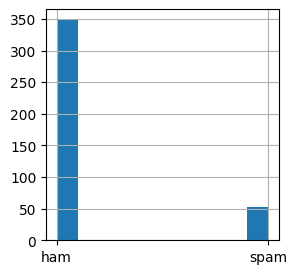

In [ ]:
data['Category'].hist(figsize=(3, 3))

**Задание**. Обработайте данные: выделите целевую переменную, произведите лемматизацию (по желанию).

In [ ]:
X = data['Message']
y = data['Category']
y[y == 'ham'] = 0
y[y == 'spam'] = 1
y = y.astype(int)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tokens = [list(filter(str.isalpha, word_tokenize(text.lower()))) for text in tqdm_notebook(X)]

<ipython-input-111-62e339a2c206>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tokens = [list(filter(str.isalpha, word_tokenize(text.lower()))) for text in tqdm_notebook(X)]


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
tokens[0]

['today',
 'is',
 'sorry',
 'if',
 'ever',
 'i',
 'was',
 'angry',
 'with',
 'you',
 'if',
 'ever',
 'i',
 'misbehaved',
 'or',
 'hurt',
 'you',
 'plz',
 'plz',
 'just',
 'slap',
 'urself',
 'bcoz',
 'its',
 'ur',
 'fault',
 'i',
 'basically',
 'good']

In [ ]:
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
X = [' '.join([lemmatizer.lemmatize(word) for word in array]) for array in tqdm_notebook(tokens)]

<ipython-input-114-f0c834053a02>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X = [' '.join([lemmatizer.lemmatize(word) for word in array]) for array in tqdm_notebook(tokens)]


  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
X[0]

'today is sorry if ever i wa angry with you if ever i misbehaved or hurt you plz plz just slap urself bcoz it ur fault i basically good'

## Обучение первого варианта модели
**Задание.** Выделите (только для этого пункта) из data_train тестовую часть. Обучите какую-то из моделей, которые мы использовали на семинаре, и посчитайте качество на тестовых данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
y_train = y_train.values
y_test = y_test.values

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [ ]:
vectorizer.fit(X_train)

CountVectorizer()

In [ ]:
vocabulary = vectorizer.get_feature_names_out()
print('Размер словаря: %d' % len(vocabulary))

description_count = vectorizer.transform(X_train)
top_tokens, _ = zip(*sorted(zip(vocabulary, description_count.sum(axis=0).getA1()), key = lambda x: x[1], reverse=True)[:10])
print('топ 10 слов: %s'%'; '.join(top_tokens))

Размер словаря: 1372
топ 10 слов: you; to; the; and; in; my; for; your; is; it


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [ ]:
vocabulary = vectorizer.get_feature_names_out()
print('Размер словаря: %d' % len(vocabulary))

description_count = vectorizer.transform(X_train)
top_tokens, _ = zip(*sorted(zip(vocabulary, description_count.sum(axis=0).getA1()), key = lambda x: x[1], reverse=True)[:10])
print('топ 10 слов: %s'%'; '.join(top_tokens))

Размер словаря: 1270
топ 10 слов: call; ur; get; love; ok; day; need; come; go; lt


In [ ]:
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression().fit(X_train_bow, y_train)

In [ ]:
y_pred = logistic_model.predict_proba(X_test_bow)[:, 1]

In [ ]:
y_pred

array([0.04190511, 0.04906182, 0.02995884, 0.0297114 , 0.04761643,
       0.03725135, 0.08135776, 0.51222266, 0.02591318, 0.03549151,
       0.024871  , 0.84596631, 0.07914598, 0.02923897, 0.01756107,
       0.02707939, 0.02572545, 0.108149  , 0.03501134, 0.02773348,
       0.70507096, 0.0178582 , 0.38175398, 0.02740237, 0.02452304,
       0.03640203, 0.03122292, 0.03050335, 0.32993209, 0.0429703 ,
       0.04227149, 0.03025735, 0.03846975, 0.04697913, 0.03747837,
       0.04023341, 0.69991649, 0.02581959, 0.05601012, 0.03240985,
       0.02366536, 0.03076158, 0.01651604, 0.01138189, 0.02903312,
       0.06168842, 0.02432386, 0.04525153, 0.70612607, 0.03638278,
       0.02993019, 0.03828995, 0.01262557, 0.01674506, 0.01650174,
       0.01490189, 0.0354005 , 0.03240985, 0.01306337, 0.0977333 ,
       0.01579185, 0.02542881, 0.02528939, 0.03570809, 0.2308836 ,
       0.04289999, 0.03002989, 0.02241408, 0.0288818 , 0.36827396,
       0.0444919 , 0.03612132, 0.02930057, 0.03292735, 0.02485

0.9207142857142858


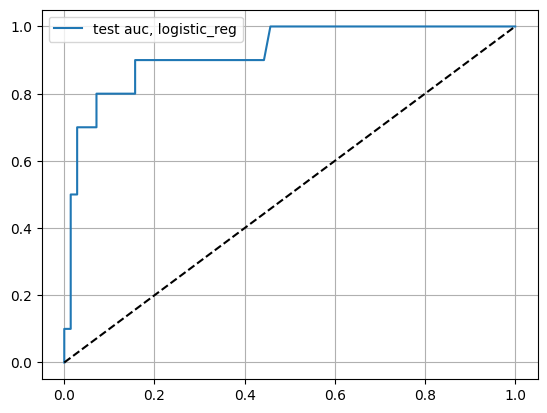

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.plot(*roc_curve(y_test, y_pred)[:2], label='test auc, logistic_reg')
plt.plot([0, 1], [0, 1], '--', color='black')
plt.grid()
plt.legend()
print(roc_auc_score(y_test, y_pred))

## Написание пайплайна тестирования
Задание. Напишите схему кросс-валидации, которая будет тестировать качество модели с данными параметрами.

In [ ]:
X_bow = vectorizer.transform(X)

In [ ]:
from sklearn.model_selection import KFold
from tqdm import tqdm

def validation(model, X, y):
    cv = KFold(n_splits=5)
    metrics = []

    for train_index, test_index in tqdm(cv.split(X)):
        X_tr, y_tr = X[train_index], y[train_index]
        X_tst, y_tst = X[test_index], y[test_index]
        logistic_model.fit(X_tr, y_tr)
        pred_val = logistic_model.predict_proba(X_tst)[:, 1]
        metrics.append(roc_auc_score(y_tst, pred_val))
    return metrics

In [ ]:
validation(logistic_model, X_bow, y)

5it [00:00, 59.53it/s]


[0.9558823529411764,
 0.9497435897435897,
 0.9592857142857143,
 0.9342723004694835,
 0.9819819819819819]

## Выбор лучшей модели
Протестируйте с помощью написанного пайплайна несколько моделей, которые мы рассматривали на семинаре. Выберите ту из них, которая дает лучшее среднее качество на кросс-валидации.

## Обучение финальной модели
После выбора лучшей модели, обучите ее на всех доступных данных (`data_train`).

## Применение модели на data_scoring и формирование submission
Загрузите данные из `data_scoring.csv`. Обработайте их так же, как вы обработали `data_train.csv`. Примените лучшую модель и сформируйте submission. Сдайте ее на Stepik.

**Обратите внимание, что метрика, используемая в задании --- ROC-AUC. Поэтому вам необходимо предсказать не класс, а вероятность класса `spam`.**

In [ ]:
data_scoring = pd.read_csv('data_scoring.csv')
data_scoring.head(10)

,Message
0,"Hurry up, I've been weed-deficient for like th..."
1,Sounds like a plan! Cardiff is still here and ...
2,Is it your yahoo boys that bring in the perf? ...
3,"K, I'll work something out"
4,Hi im having the most relaxing time ever! we h...
5,"Piggy, r u awake? I bet u're still sleeping. I..."
6,No just send to you. Bec you in temple na.
7,That's the trouble with classes that go well -...
8,Santa calling! Would your little ones like a c...
9,"If you don't, your prize will go to another cu..."


In [ ]:
X_scoring = data_scoring['Message']

In [ ]:
tokens_test = [list(filter(str.isalpha, word_tokenize(text.lower()))) for text in tqdm_notebook(X_scoring)]#YOUR CODE

<ipython-input-165-757dcb5bb067>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tokens_test = [list(filter(str.isalpha, word_tokenize(text.lower()))) for text in tqdm_notebook(X_scoring)]#YOUR CODE


  0%|          | 0/5172 [00:00<?, ?it/s]

In [ ]:
tokens_test[0]

['hurry', 'up', 'i', 'been', 'for', 'like', 'three', 'days']

In [ ]:
data_test = [' '.join([lemmatizer.lemmatize(word) for word in array]) for array in tqdm_notebook(tokens_test)]

<ipython-input-167-14a991aad9fa>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  data_test = [' '.join([lemmatizer.lemmatize(word) for word in array]) for array in tqdm_notebook(tokens_test)]


  0%|          | 0/5172 [00:00<?, ?it/s]

In [ ]:
data_test[-1]

'tell them no need to investigate about me anywhere'

In [ ]:
data_test_trans = vectorizer.transform(data_test)

In [ ]:
y_scoring = logistic_model.predict_proba(data_test_trans)[:, 1]# YOUR CODE. Сюда запишите вероятности принадлежности к
# классу "spam" полученные с помощью модели на data_scoring.csv

In [ ]:
y_scoring

array([0.05862279, 0.01779301, 0.03667546, ..., 0.18449637, 0.05395901,
       0.04368101])

In [ ]:
pd.Series(y_scoring, name='score').to_csv('submission.csv', index=None)